In [198]:
import os 
import glob
import pandas as pd

import cv2
from torch.utils.data import Dataset
#Img Augment
import imgaug as ia
import imgaug.augmenters as iaa
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage
from torchvision import transforms as T
import matplotlib.patches as patches


## Model Workflow
How R-CNN works can be summarized as follows:

1. *Pre-train a CNN* network on image classification tasks; for example, VGG or ResNet trained on ImageNet dataset. The classification task involves N classes.
    NOTE: You can find a pre-trained AlexNet in Caffe Model Zoo. I don’t think you can find it in Tensorflow, but Tensorflow-slim model library provides pre-trained ResNet, VGG, and others.

2. Propose category-independent regions of interest by selective search (~2k candidates per image). Those regions may contain target objects and they are of different sizes.
3. Region candidates are warped to have a fixed size as required by CNN.
4. Continue fine-tuning the CNN on warped proposal regions for K + 1 classes; The additional one class refers to the background (no object of interest). In the fine-tuning stage, we should use a much smaller learning rate and the mini-batch oversamples the positive cases because most proposed regions are just background.
5. Given every image region, one forward propagation through the CNN generates a feature vector. This feature vector is then consumed by a binary SVM trained for each class independently.
6. The positive samples are proposed regions with IoU (intersection over union) overlap threshold >= 0.3, and negative samples are irrelevant others.
To reduce the localization errors, a regression model is trained to correct the predicted detection window on bounding box correction offset using CNN features.

## Pretrain a CNN network on image classification

In [199]:
import torch
from torchvision import models
mobilenet = models.mobilenet_v2(pretrained=True)
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
                              
print(f'Num of parameters: {count_parameters(mobilenet)}')


Num of parameters: 3504872


In [200]:
from dataload import xml_to_csv,PetData

In [201]:
##Loading data
root_path="D:/Dataset/Pet_Data/"
img_path=os.path.join(root_path,"images")
annotation_path=os.path.join(root_path,"annotations/xmls")           
annots = glob.glob(annotation_path+"/*.xml")

class PetData_(PetData):

    
    def __init__(self, dataframe,train=False):
        super().__init__(dataframe,train=False)
#         self.df=dataframe
#         if train:
#             self.transform=iaa.Sequential([iaa.Resize((224,224))])

#         else:
#             self.transform=iaa.Sequential([iaa.Resize((224,224))])
        
#         self.torch_transform = T.Compose([T.ToTensor(),
#                                 T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
        
    def __len__(self):
        return len(self.df)

    
    def __getitem__(self, idx):
        fn,target,xmin,ymin,xmax,ymax=self.df.iloc[idx] #
        im=cv2.cvtColor(cv2.imread(fn),cv2.COLOR_BGR2RGB) ##Load Img
        
        class_label=list([target])  ##Class
        bbs=BoundingBoxesOnImage([BoundingBox(xmin,ymin,xmax,ymax,label=class_label)], shape=im.shape) #BBox
        
        image_aug, bbs_aug = self.transform(image=im, bounding_boxes=bbs) #Transformation
     #   image_aug=self.torch_transform(image_aug)
        return image_aug,bbs_aug,class_label
    
    
df=xml_to_csv(annots,img_path)
df.head()

BATCH_SIZE = 20
train_ds = PetData_(df, train=True)


def collate_fn(batch):
    return tuple(zip(*batch))
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE
                                       , collate_fn=collate_fn)

## Selective Search from [AlpacaDB](https://github.com/AlpacaDB/selectivesearch)
1. Similarity
    - Color Similarity
    - Texture Similarity
    - Size Similarity
    - Shape Compatiblity

    

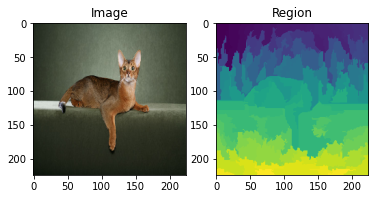

In [292]:
import skimage.io
import skimage.feature
import skimage.color
import skimage.transform
import skimage.util
import skimage.segmentation
import numpy as np

'''
Elect few regions using felzenszwwalb segmentation to reduce the number of process

'''
scale=1.0 
sigma=0.8
min_size=120
def generate_regions(im_orig, scale, sigma, min_size):
    """
        get segment using felzenswalb https://en.wikipedia.org/wiki/Minimum_spanning_tree-based_segmentations
    """

    # open the Image
    im_mask = skimage.segmentation.felzenszwalb(
        im_orig, scale=scale, sigma=sigma,
        min_size=min_size)

    im_mask=np.concatenate((im_orig,np.array([im_mask]).transpose(1,2,0)),axis=2)
    return im_mask
img_with_region=generate_regions(train_ds[0][0], scale, sigma, min_size)
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,2)
ax[0].set_title("Image")
ax[0].imshow(img_with_region[:,:,0:3].astype(int))
ax[1].set_title("Region")
ax[1].imshow(img_with_region[:,:,3])

In [293]:
def _calc_colour_hist(img):
    """
        calculate colour histogram for each region
        the size of output histogram will be BINS * COLOUR_CHANNELS(3)
        number of bins is 25 as same as [uijlings_ijcv2013_draft.pdf]
        extract HSV
    """

    BINS = 25
    hist = np.array([])

    for colour_channel in (0, 1, 2):

        # extracting one colour channel
        c = img[:, colour_channel]

        # calculate histogram for each colour and join to the result
        hist = np.concatenate(
            [hist] + [np.histogram(c, BINS, (0.0, 255.0))[0]])

    # L1 normalize
    hist = hist / len(img)

    return hist

def _calc_texture_gradient(img):
    """
        calculate texture gradient for entire image
        The original SelectiveSearch algorithm proposed Gaussian derivative
        for 8 orientations, but we use LBP instead.
        output will be [height(*)][width(*)]
    """
    ret = np.zeros((img.shape[0], img.shape[1], img.shape[2]))

    for colour_channel in (0, 1, 2):
        ret[:, :, colour_channel] = skimage.feature.local_binary_pattern(
            img[:, :, colour_channel], 8, 1.0)

    return ret
def _calc_texture_hist(img):
    """
        calculate texture histogram for each region
        calculate the histogram of gradient for each colours
        the size of output histogram will be
            BINS * ORIENTATIONS * COLOUR_CHANNELS(3)
    """
    BINS = 10

    hist = np.array([])

    for colour_channel in (0, 1, 2):

        # mask by the colour channel
        fd = img[:, colour_channel]

        # calculate histogram for each orientation and concatenate them all
        # and join to the result
        hist = np.concatenate(
            [hist] + [np.histogram(fd, BINS, (0.0, 1.0))[0]])

    # L1 Normalize
    hist = hist / len(img)

    return hist

def extract_region_information(img,debug=True):
    R={}
    hsv = skimage.color.rgb2hsv(img[:, :, :3])
    
    #Extraction region information on its bounding box
    for y, i in enumerate(img):
        for x, (r, g, b, l) in enumerate(i):

            # initialize a new region if it does not exist
            if l not in R:
                R[l] = {
                    "x_min": img.shape[1], "y_min": img.shape[0],
                    "x_max": 0, "y_max": 0, "labels": [l]}

            # bounding box
            if R[l]["x_min"] > x:
                R[l]["x_min"] = x
            if R[l]["y_min"] > y:
                R[l]["y_min"] = y
            if R[l]["x_max"] < x:
                R[l]["x_max"] = x
            if R[l]["y_max"] < y:
                R[l]["y_max"] = y
    if debug:
        fig, ax = plt.subplots()
        ax.imshow(np.array(img[:, :, :3]))
        for region in R.keys():    
            bbox=R[region]
            xy=(bbox['x_min'],bbox['y_min'])
            width=bbox['x_max']-bbox['x_min']
            height=bbox['y_max']-bbox['y_min']
            ax.add_patch(
            patches.Rectangle(
                xy,
                width,
                height,
                edgecolor = 'blue',
                fill=False ) )
            
    tex_grad = _calc_texture_gradient(img)
    for k, v in list(R.items()):

        # colour histogram
        masked_pixels = hsv[:, :, :][img[:, :, 3] == k]
        R[k]["size"] = len(masked_pixels / 4)
        R[k]["hist_c"] = _calc_colour_hist(masked_pixels)

        # texture histogram
        R[k]["hist_t"] = _calc_texture_hist(tex_grad[:, :][img[:, :, 3] == k])

    return R
            
            
def _extract_neighbours(regions):

    def intersect(a, b):
        if (a["x_min"] < b["x_min"] < a["x_max"]
                and a["y_min"] < b["y_min"] < a["y_max"]) or (
            a["x_min"] < b["x_max"] < a["x_max"]
                and a["y_min"] < b["y_max"] < a["y_max"]) or (
            a["x_min"] < b["x_min"] < a["x_max"]
                and a["y_min"] < b["y_max"] < a["y_max"]) or (
            a["x_min"] < b["x_max"] < a["x_max"]
                and a["y_min"] < b["y_min"] < a["y_max"]):
            return True
        return False

    R = list(regions.items())
    neighbours = []
    for cur, a in enumerate(R[:-1]):
        for b in R[cur + 1:]:
            if intersect(a[1], b[1]):
                neighbours.append((a, b))

    return neighbours


def _merge_regions(r1, r2):
    new_size = r1["size"] + r2["size"]
    rt = {
        "x_min": min(r1["x_min"], r2["x_min"]),
        "y_min": min(r1["y_min"], r2["y_min"]),
        "x_max": max(r1["x_max"], r2["x_max"]),
        "y_max": max(r1["y_max"], r2["y_max"]),
        "size": new_size,
        "hist_c": (
            r1["hist_c"] * r1["size"] + r2["hist_c"] * r2["size"]) / new_size,
        "hist_t": (
            r1["hist_t"] * r1["size"] + r2["hist_t"] * r2["size"]) / new_size,
        "labels": r1["labels"] + r2["labels"]
    }
    return rt

def _calc_sim(r1, r2, imsize):
    return (_sim_colour(r1, r2) + _sim_texture(r1, r2)
            + _sim_size(r1, r2, imsize) + _sim_fill(r1, r2, imsize))

def _sim_colour(r1, r2):
    """
        calculate the sum of histogram intersection of colour
    """
    return sum([min(a, b) for a, b in zip(r1["hist_c"], r2["hist_c"])])


def _sim_texture(r1, r2):
    """
        calculate the sum of histogram intersection of texture
    """
    return sum([min(a, b) for a, b in zip(r1["hist_t"], r2["hist_t"])])


def _sim_size(r1, r2, imsize):
    """
        calculate the size similarity over the image
    """
    return 1.0 - (r1["size"] + r2["size"]) / imsize
def _sim_fill(r1, r2, imsize):
    """
        calculate the fill similarity over the image
    """
    bbsize = (
        (max(r1["x_max"], r2["x_max"]) - min(r1["x_min"], r2["x_min"]))
        * (max(r1["y_max"], r2["y_max"]) - min(r1["y_min"], r2["y_min"]))
    )
    return 1.0 - (bbsize - r1["size"] - r2["size"]) / imsize


def _calc_sim(r1, r2, imsize):
    return (_sim_colour(r1, r2) + _sim_texture(r1, r2)
            + _sim_size(r1, r2, imsize) + _sim_fill(r1, r2, imsize))


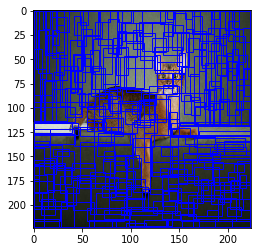

In [294]:
imsize = segmented.shape[0] * segmented.shape[1]
R=extract_region_information(segmented)
neighbours = _extract_neighbours(R)
S = {}
for (ai, ar), (bi, br) in neighbours:
    S[(ai, bi)] = _calc_sim(ar, br, imsize)

# hierarchal search
while S != {}:

    # get highest similarity
    i, j = sorted(S.items(), key=lambda i: i[1])[-1][0]

    # merge corresponding regions
    t = max(R.keys()) + 1.0
    R[t] = _merge_regions(R[i], R[j])

    # mark similarities for regions to be removed
    key_to_delete = []
    for k, v in list(S.items()):
        if (i in k) or (j in k):
            key_to_delete.append(k)

    # remove old similarities of related regions
    for k in key_to_delete:
        del S[k]

    # calculate similarity set with the new region
    for k in [a for a in key_to_delete if a != (i, j)]:
        n = k[1] if k[0] in (i, j) else k[0]
        S[(t, n)] = _calc_sim(R[t], R[n], imsize)

regions = []
for k, r in list(R.items()):
    regions.append({
        'rect': (
            r['x_min'], r['y_min'],
            r['x_max'] - r['x_min'], r['y_max'] - r['y_min']),
        'size': r['size'],
        'labels': r['labels']
    })



In [295]:
len(regions)

577

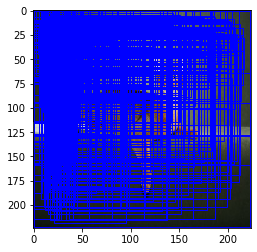

In [296]:
fig, ax = plt.subplots()
ax.imshow(np.array(img_with_region[:,:,0:3][:, :, :3]))
for region in regions:    
    bbox=region['rect']
    xy=(bbox[0],bbox[1])
    width=bbox[2]-bbox[0]
    height=bbox[3]-bbox[1]
    ax.add_patch(
    patches.Rectangle(
        xy,
        width,
        height,
        edgecolor = 'blue',
        fill=False ) )